生成90维耦合Lorenz系统数据集 (丢弃瞬态)
📋 数据生成配置:
   - 最终数据点数: 10000
   - 瞬态点数: 2000
   - 总计算点数: 12000
   - 噪声类型: 观测噪声 (不影响动力学)

🔹 第一步：生成无噪声数据集
----------------------------------------
正在求解90维耦合Lorenz系统...
耦合强度: 0.3
总时间范围 (含瞬态): (-40.004000400040006, 200)
最终时间范围: (0, 200)
总采样点数: 12000 (瞬态: 2000, 保留: 10000)
时间步长: 0.020002
瞬态时间: 40.004
数据类型:  (无噪声)
求解成功!
已丢弃前 2000 个瞬态点
最终数据形状: (10000, 90)
最终时间范围: [0.000, 200.000]

=== 无噪声系统分析 ===
数据形状: (10000, 90)
时间点数: 10000
维度数: 90

各维度均值范围: [-1.855, 23.656]
各维度标准差范围: [7.498, 9.136]

前5个振子(x,y,z)的平均标准差:
振子  0: x=7.75, y=9.07, z=8.51
振子  1: x=7.68, y=9.05, z=8.66
振子  2: x=7.65, y=9.02, z=8.60
振子  3: x=7.50, y=8.90, z=8.70
振子  4: x=7.66, y=9.13, z=8.88

正在生成CSV数据集...
时间单位设置: 1 Lorenz时间单位 = 5.0 秒
数据已保存到: coupled_lorenz_clean.csv
数据形状: (10000, 91)
日期范围: 2016-01-01 00:00:00 到 2016-01-01 00:16:40
总时间跨度: 0 days 00:16:40
数据点之间的时间间隔: 0.100 秒

数据预览:
                        date         x1         x2         x3        x4  \
0 2016-01-01 00:00:00.000000  16.978657  22.232273  3

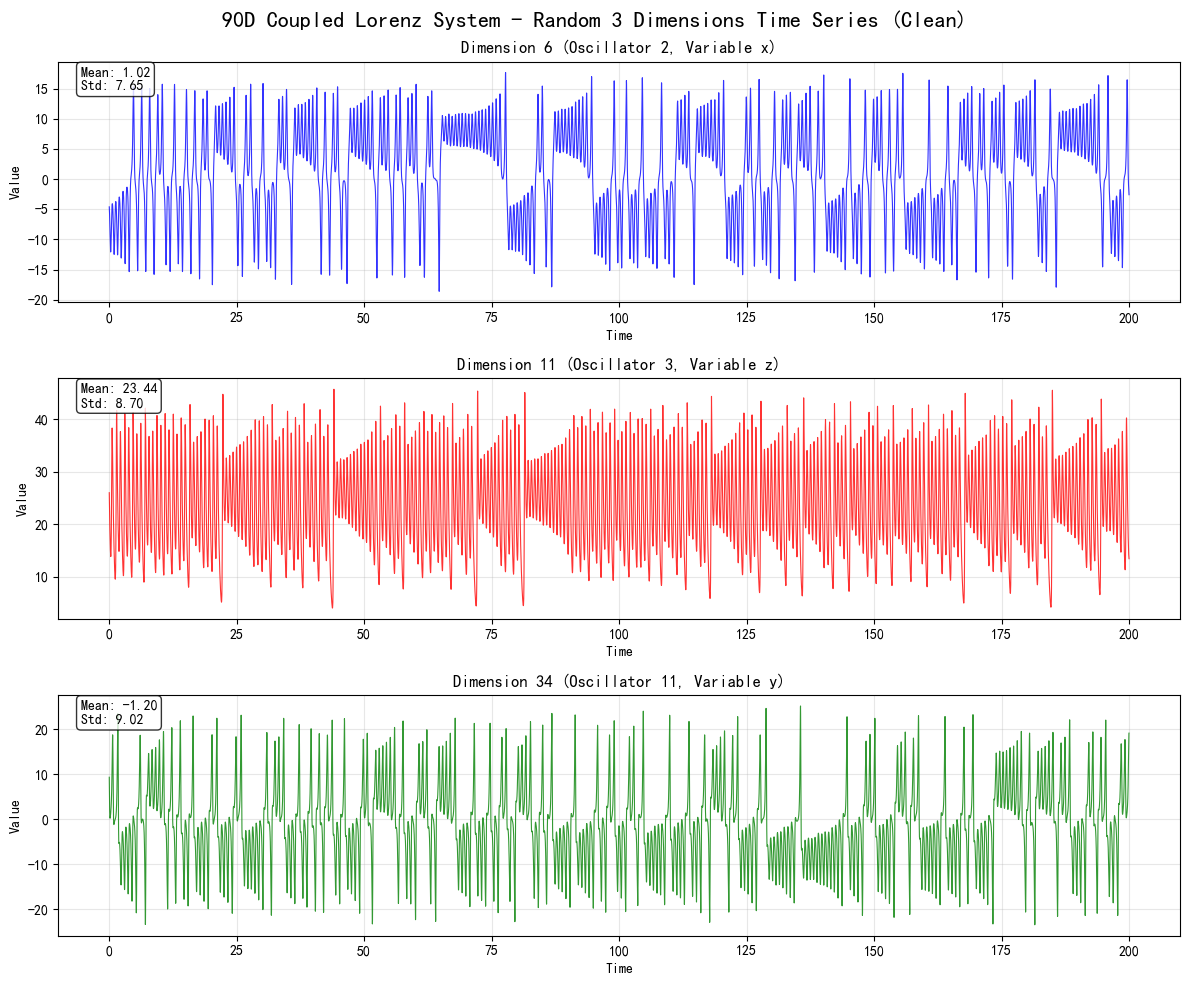

随机选择的维度: [6, 11, 34]


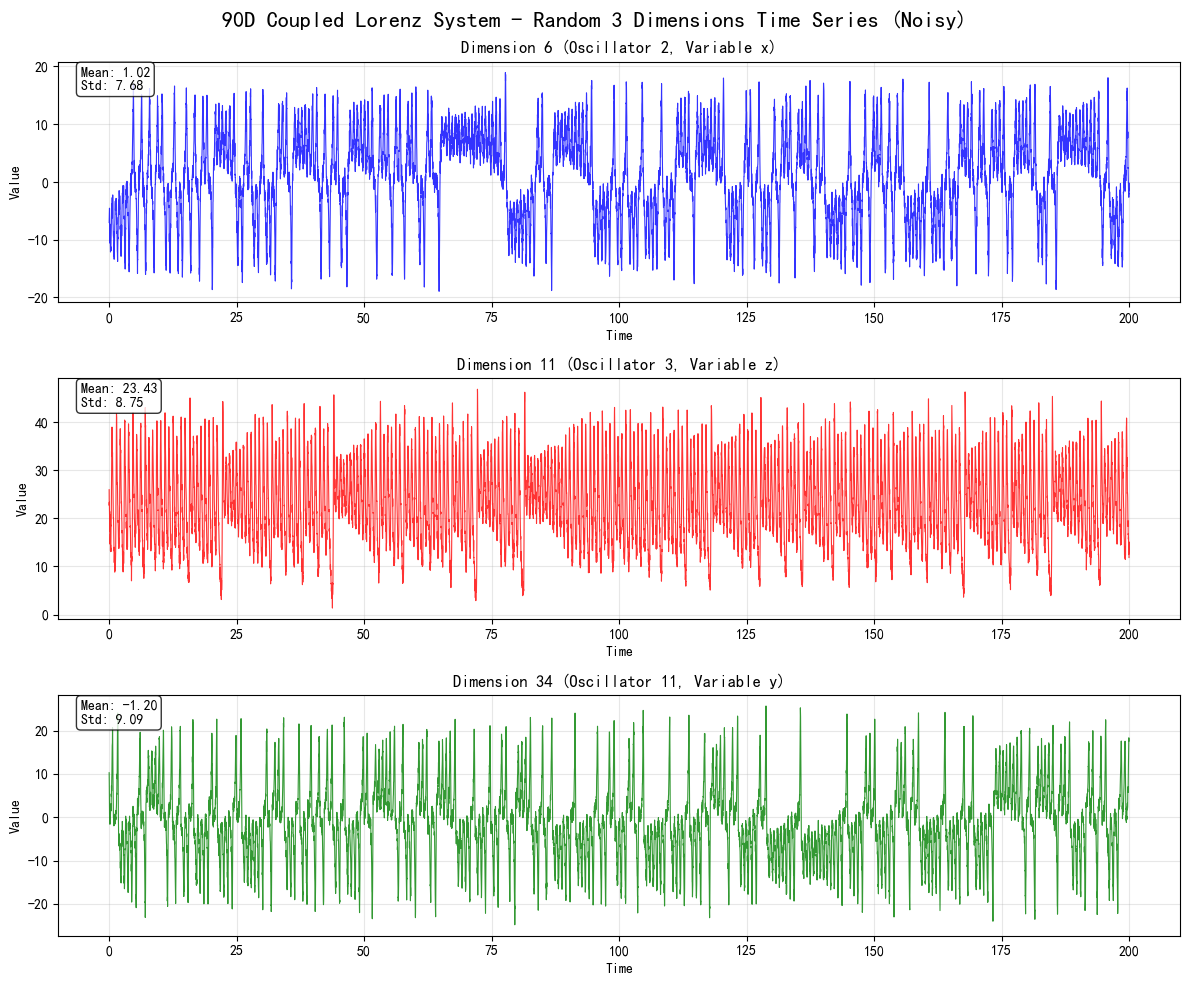


数据生成完成总结
✅ 无噪声数据集: coupled_lorenz_clean.csv
   - 时间序列长度: 10000
   - 数据维度: (10000, 90)
   - 时间范围: [0.000, 200.000]
   - 文件大小: 约 6.94 MB
✅ 有观测噪声数据集: coupled_lorenz_noisy.csv
   - 观测噪声标准差: 1.0
   - 数据维度: (10000, 90)
   - 文件大小: 约 6.94 MB

📊 最终数据集参数:
   - 耦合强度: 0.3 (适合预测任务)
   - 有效数据点: 10000
   - 丢弃瞬态点: 2000
   - 时间步长: 0.020002
   - 噪声类型: 观测噪声 (保持动力学特性)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
import pandas as pd
from datetime import datetime, timedelta

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  
plt.rcParams['axes.unicode_minus'] = False

def coupled_lorenz_system(t, state, sigma=10.0, rho=28.0, beta=8.0/3.0, coupling=0.1):
    """
    90维耦合Lorenz系统 (30个Lorenz振子，每个3维)
    采用环形耦合方式
    """
    n_oscillators = 30
    dydt = np.zeros(90)
    
    # 将90维状态向量重塑为30x3的矩阵，便于处理
    state_matrix = state.reshape(n_oscillators, 3)
    
    for i in range(n_oscillators):
        x, y, z = state_matrix[i]
        
        # 环形耦合：每个振子与相邻的两个振子耦合
        left_neighbor = (i - 1) % n_oscillators
        right_neighbor = (i + 1) % n_oscillators
        
        # 耦合项（只在x方向耦合）
        coupling_term = coupling * (
            state_matrix[left_neighbor, 0] + state_matrix[right_neighbor, 0] - 2*x
        )
        
        # Lorenz方程 + 耦合项
        dydt[i*3] = sigma * (y - x) + coupling_term  # dx/dt
        dydt[i*3 + 1] = x * (rho - z) - y             # dy/dt  
        dydt[i*3 + 2] = x * y - beta * z              # dz/dt
    
    return dydt

def generate_data(t_span=(0, 50), n_points=10000, transient_points=2000, 
                 coupling_strength=0.3, noise_std=0.0, noise_seed=None):
    """
    生成耦合Lorenz系统的时间序列数据，自动丢弃瞬态
    
    参数:
    - t_span: 最终数据的时间范围 (start, end)
    - n_points: 最终保留的数据点数
    - transient_points: 丢弃的瞬态点数
    - coupling_strength: 耦合强度
    - noise_std: 高斯观测噪声标准差，0表示无噪声
    - noise_seed: 噪声随机种子，None表示使用随机噪声
    """
    
    # 计算总的采样点数（包含瞬态）
    total_points = n_points + transient_points
    
    # 计算扩展的时间范围（包含瞬态时间）
    total_time_span = t_span[1] - t_span[0]
    dt = total_time_span / (n_points - 1)  # 最终数据的时间步长
    transient_time = transient_points * dt
    extended_t_span = (t_span[0] - transient_time, t_span[1])
    
    # 随机初始条件
    np.random.seed(42)  # 为了可重现性
    initial_conditions = np.random.randn(90) * 0.1
    
    # 扩展的时间点（包含瞬态）
    t_eval = np.linspace(extended_t_span[0], extended_t_span[1], total_points)
    
    noise_info = f", 观测噪声标准差: {noise_std}" if noise_std > 0 else " (无噪声)"
    print("正在求解90维耦合Lorenz系统...")
    print(f"耦合强度: {coupling_strength}")
    print(f"总时间范围 (含瞬态): {extended_t_span}")
    print(f"最终时间范围: {t_span}")
    print(f"总采样点数: {total_points} (瞬态: {transient_points}, 保留: {n_points})")
    print(f"时间步长: {dt:.6f}")
    print(f"瞬态时间: {transient_time:.3f}")
    print(f"数据类型: {noise_info}")
    
    # 求解ODE
    sol = solve_ivp(
        coupled_lorenz_system, 
        extended_t_span, 
        initial_conditions,
        args=(10.0, 28.0, 8.0/3.0, coupling_strength),
        t_eval=t_eval,
        method='RK45',
        rtol=1e-8,
        atol=1e-10
    )
    
    if sol.success:
        print("求解成功!")
        
        # 丢弃瞬态数据
        t_final = sol.t[transient_points:]  # 丢弃前transient_points个时间点
        data_final = sol.y[:, transient_points:].T  # 丢弃前transient_points列，转置为(n_points, 90)
        
        # 重新调整时间起点为t_span[0]
        t_final = t_final - t_final[0] + t_span[0]
        
        print(f"已丢弃前 {transient_points} 个瞬态点")
        print(f"最终数据形状: {data_final.shape}")
        print(f"最终时间范围: [{t_final[0]:.3f}, {t_final[-1]:.3f}]")
        
        # 添加观测噪声（如果需要）
        if noise_std > 0:
            if noise_seed is not None:
                np.random.seed(noise_seed)
            noise = np.random.normal(0, noise_std, data_final.shape)
            data_noisy = data_final + noise
            print(f"已添加标准差为{noise_std}的观测噪声")
            return t_final, data_noisy
        else:
            return t_final, data_final
    else:
        print("求解失败:", sol.message)
        return None, None

def visualize_random_dimensions(t, data, n_dims=3, title_suffix=""):
    """随机选择3个维度进行可视化（使用英文标题）"""
    
    if data is None:
        print("没有数据可以可视化")
        return
    
    # 随机选择3个维度
    random.seed(123)  # 为了可重现性
    selected_dims = random.sample(range(90), n_dims)
    selected_dims.sort()
    
    print(f"随机选择的维度: {selected_dims}")
    
    # 创建子图
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    main_title = f'90D Coupled Lorenz System - Random 3 Dimensions Time Series{title_suffix}'
    fig.suptitle(main_title, fontsize=16)
    
    colors = ['blue', 'red', 'green']
    
    for i, (dim, ax, color) in enumerate(zip(selected_dims, axes, colors)):
        ax.plot(t, data[:, dim], color=color, linewidth=0.8, alpha=0.8)
        ax.set_title(f'Dimension {dim} (Oscillator {dim//3}, Variable {["x", "y", "z"][dim%3]})', fontsize=12)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        # 添加一些统计信息
        mean_val = np.mean(data[:, dim])
        std_val = np.std(data[:, dim])
        ax.text(0.02, 0.98, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return selected_dims

def save_to_csv(t, data, filename='coupled_lorenz_dataset.csv', 
                start_date='2016-01-01 00:00:00', time_unit_seconds=1.0):
    """
    将数据保存为CSV格式，包含日期时间列
    
    参数:
    - t: 时间数组
    - data: 90维数据
    - filename: 保存的文件名
    - start_date: 开始日期时间
    - time_unit_seconds: Lorenz系统中1个时间单位对应的真实秒数
    """
    
    if data is None:
        print("没有数据可以保存")
        return None
    
    print(f"\n正在生成CSV数据集...")
    print(f"时间单位设置: 1 Lorenz时间单位 = {time_unit_seconds} 秒")
    
    # 创建日期时间序列
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    
    # 根据实际的时间步长计算日期时间
    dates = []
    for time_val in t:
        real_seconds = time_val * time_unit_seconds
        date_time = start_datetime + timedelta(seconds=real_seconds)
        dates.append(date_time)
    
    # 创建DataFrame
    df_data = {'date': dates}
    
    # 添加90个维度的数据列 (x1 到 x90)
    for i in range(90):
        df_data[f'x{i+1}'] = data[:, i]
    
    df = pd.DataFrame(df_data)
    
    # 保存到CSV
    df.to_csv(filename, index=False)
    
    print(f"数据已保存到: {filename}")
    print(f"数据形状: {df.shape}")
    print(f"日期范围: {df['date'].iloc[0]} 到 {df['date'].iloc[-1]}")
    print(f"总时间跨度: {df['date'].iloc[-1] - df['date'].iloc[0]}")
    
    # 计算实际的时间间隔
    if len(df) > 1:
        time_diff = (df['date'].iloc[1] - df['date'].iloc[0]).total_seconds()
        print(f"数据点之间的时间间隔: {time_diff:.3f} 秒")
    
    # 显示前几行作为预览
    print(f"\n数据预览:")
    print(df.head())
    
    return df

def analyze_system(data, dataset_name=""):
    """简单的系统分析"""
    if data is None:
        return
    
    print(f"\n=== {dataset_name}系统分析 ===")
    print(f"数据形状: {data.shape}")
    print(f"时间点数: {data.shape[0]}")
    print(f"维度数: {data.shape[1]}")
    
    # 计算每个维度的统计量
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    print(f"\n各维度均值范围: [{np.min(means):.3f}, {np.max(means):.3f}]")
    print(f"各维度标准差范围: [{np.min(stds):.3f}, {np.max(stds):.3f}]")
    
    # 分析每个振子的行为
    print("\n前5个振子(x,y,z)的平均标准差:")
    for i in range(min(5, 30)):  # 只显示前5个振子，避免输出过长
        x_std = stds[i*3]
        y_std = stds[i*3 + 1] 
        z_std = stds[i*3 + 2]
        print(f"振子 {i:2d}: x={x_std:.2f}, y={y_std:.2f}, z={z_std:.2f}")

def compare_noise_effect(data_clean, data_noisy):
    """比较观测噪声对数据的影响"""
    print("\n=== 观测噪声影响分析 ===")
    
    # 计算信噪比 (SNR)
    signal_power = np.mean(data_clean**2, axis=0)
    noise_power = np.mean((data_noisy - data_clean)**2, axis=0)
    snr = 10 * np.log10(signal_power / noise_power)
    
    print(f"平均信噪比 (SNR): {np.mean(snr):.2f} dB")
    print(f"SNR范围: [{np.min(snr):.2f}, {np.max(snr):.2f}] dB")
    
    # 计算相关系数
    correlations = []
    for i in range(90):
        corr = np.corrcoef(data_clean[:, i], data_noisy[:, i])[0, 1]
        correlations.append(corr)
    
    print(f"平均相关系数: {np.mean(correlations):.4f}")
    print(f"相关系数范围: [{np.min(correlations):.4f}, {np.max(correlations):.4f}]")
    
    # 计算噪声水平
    actual_noise_std = np.sqrt(np.mean(noise_power))
    print(f"实际噪声标准差: {actual_noise_std:.3f}")

if __name__ == "__main__":
    # 参数设置
    time_span = (0, 200)           # 最终数据的时间范围
    n_points = 10000               # 最终保留的数据点数
    transient_points = 2000        # 丢弃的瞬态点数
    coupling = 0.3                 # 预测任务优化的耦合强度
    noise_std = 1.0                # 观测噪声标准差
    
    print("=" * 60)
    print("生成90维耦合Lorenz系统数据集 (丢弃瞬态)")
    print("=" * 60)
    print(f"📋 数据生成配置:")
    print(f"   - 最终数据点数: {n_points}")
    print(f"   - 瞬态点数: {transient_points}")
    print(f"   - 总计算点数: {n_points + transient_points}")
    print(f"   - 噪声类型: 观测噪声 (不影响动力学)")
    
    # 1. 生成无噪声数据集
    print("\n🔹 第一步：生成无噪声数据集")
    print("-" * 40)
    t, data_clean = generate_data(
        t_span=time_span, 
        n_points=n_points,
        transient_points=transient_points,
        coupling_strength=coupling, 
        noise_std=0.0
    )
    
    if data_clean is not None:
        # 分析无噪声系统
        analyze_system(data_clean, "无噪声")
        
        # 保存无噪声数据
        df_clean = save_to_csv(
            t, data_clean, 
            'coupled_lorenz_clean.csv', 
            '2016-01-01 00:00:00', 
            time_unit_seconds=5.0
        )
    
    # 2. 生成有观测噪声数据集
    print("\n🔹 第二步：生成有观测噪声数据集")
    print("-" * 40)
    t, data_noisy = generate_data(
        t_span=time_span, 
        n_points=n_points,
        transient_points=transient_points,
        coupling_strength=coupling, 
        noise_std=noise_std,
        noise_seed=123  # 固定噪声种子，确保可重现
    )
    
    if data_noisy is not None:
        # 分析有噪声系统
        analyze_system(data_noisy, "有观测噪声")
        
        # 保存有噪声数据
        df_noisy = save_to_csv(
            t, data_noisy, 
            'coupled_lorenz_noisy.csv', 
            '2016-01-01 00:00:00', 
            time_unit_seconds=5.0
        )
    
    # 3. 比较两个数据集
    if data_clean is not None and data_noisy is not None:
        compare_noise_effect(data_clean, data_noisy)
        
        # 可视化对比（选择相同的维度）
        print("\n🔹 第三步：可视化对比")
        print("-" * 40)
        selected_dims_clean = visualize_random_dimensions(t, data_clean, title_suffix=" (Clean)")
        selected_dims_noisy = visualize_random_dimensions(t, data_noisy, title_suffix=" (Noisy)")
    
    # 4. 总结
    print("\n" + "=" * 60)
    print("数据生成完成总结")
    print("=" * 60)
    
    if data_clean is not None:
        print(f"✅ 无噪声数据集: coupled_lorenz_clean.csv")
        print(f"   - 时间序列长度: {len(t)}")
        print(f"   - 数据维度: {data_clean.shape}")
        print(f"   - 时间范围: [{t[0]:.3f}, {t[-1]:.3f}]")
        if df_clean is not None:
            file_size_clean = df_clean.memory_usage(deep=True).sum() / 1024 / 1024
            print(f"   - 文件大小: 约 {file_size_clean:.2f} MB")
    
    if data_noisy is not None:
        print(f"✅ 有观测噪声数据集: coupled_lorenz_noisy.csv")
        print(f"   - 观测噪声标准差: {noise_std}")
        print(f"   - 数据维度: {data_noisy.shape}")
        if df_noisy is not None:
            file_size_noisy = df_noisy.memory_usage(deep=True).sum() / 1024 / 1024
            print(f"   - 文件大小: 约 {file_size_noisy:.2f} MB")
    
    print(f"\n📊 最终数据集参数:")
    print(f"   - 耦合强度: {coupling} (适合预测任务)")
    print(f"   - 有效数据点: {n_points}")
    print(f"   - 丢弃瞬态点: {transient_points}")
    print(f"   - 时间步长: {(time_span[1]-time_span[0])/(n_points-1):.6f}")
    print(f"   - 噪声类型: 观测噪声 (保持动力学特性)")

生成90维耦合Lorenz系统数据集 (多种噪声标准差)
📋 数据生成配置:
   - 最终数据点数: 10000
   - 瞬态点数: 2000
   - 总计算点数: 12000
   - 噪声标准差: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
   - 总数据集数量: 11 个

🔹 第一步：生成基础干净数据
------------------------------------------------------------
正在求解90维耦合Lorenz系统...
耦合强度: 0.3
总时间范围 (含瞬态): (-40.004000400040006, 200)
最终时间范围: (0, 200)
总采样点数: 12000 (瞬态: 2000, 保留: 10000)
时间步长: 0.020002
瞬态时间: 40.004
数据类型:  (无噪声)
求解成功!
已丢弃前 2000 个瞬态点
最终数据形状: (10000, 90)
最终时间范围: [0.000, 200.000]

=== 无噪声系统分析 ===
数据形状: (10000, 90)
时间点数: 10000
维度数: 90

各维度均值范围: [-1.855, 23.656]
各维度标准差范围: [7.498, 9.136]

前5个振子(x,y,z)的平均标准差:
振子  0: x=7.75, y=9.07, z=8.51
振子  1: x=7.68, y=9.05, z=8.66
振子  2: x=7.65, y=9.02, z=8.60
振子  3: x=7.50, y=8.90, z=8.70
振子  4: x=7.66, y=9.13, z=8.88

🔹 第二步：生成不同噪声标准差的数据集
------------------------------------------------------------

>>> 正在生成数据集 1/11 (噪声标准差=0.0)

=== 无噪声系统分析 ===
数据形状: (10000, 90)
时间点数: 10000
维度数: 90

各维度均值范围: [-1.855, 23.656]
各维度标准差范围: [7.498, 9.136]

前5个振子(x,y,z)的平均标准

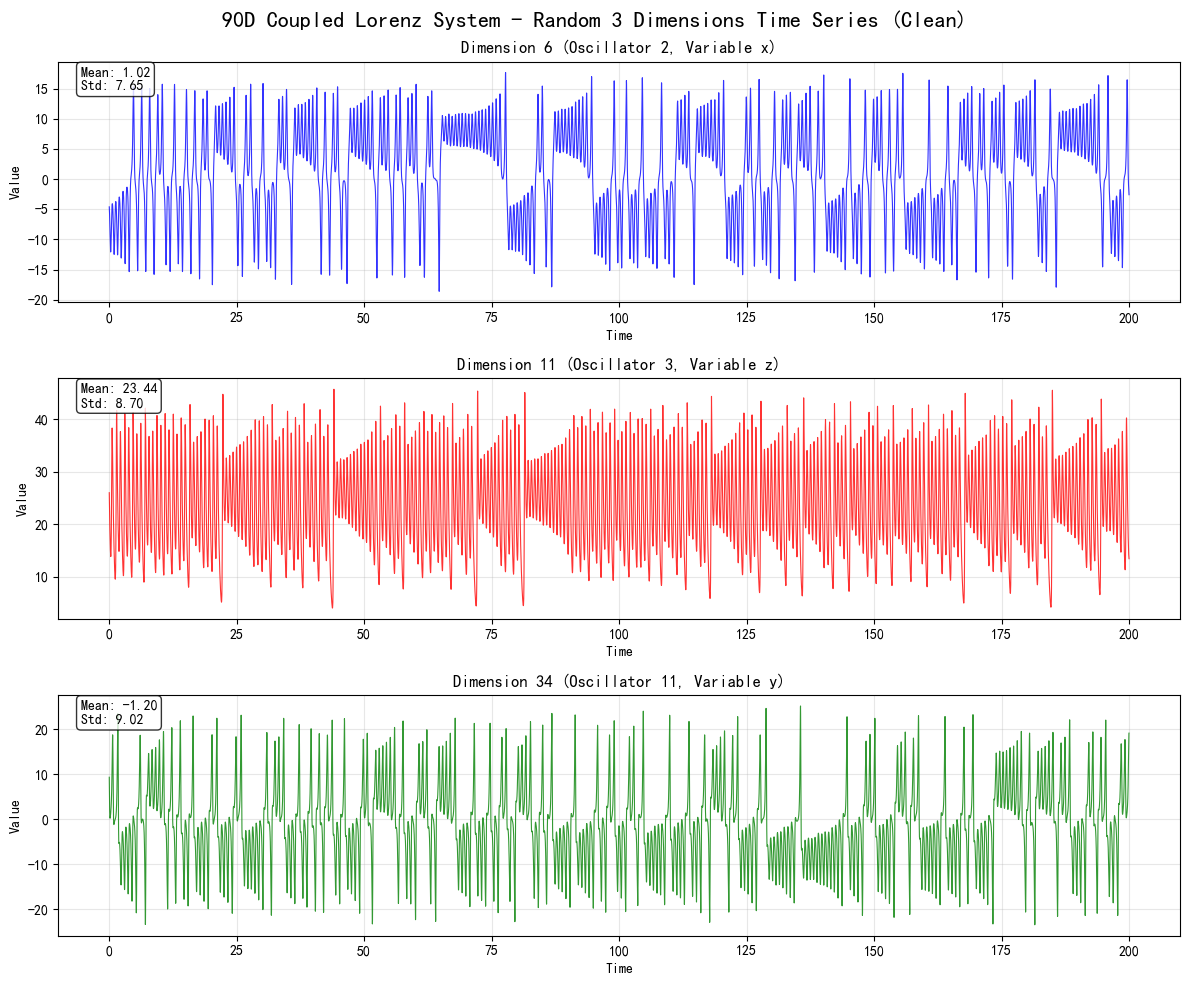

随机选择的维度: [6, 11, 34]


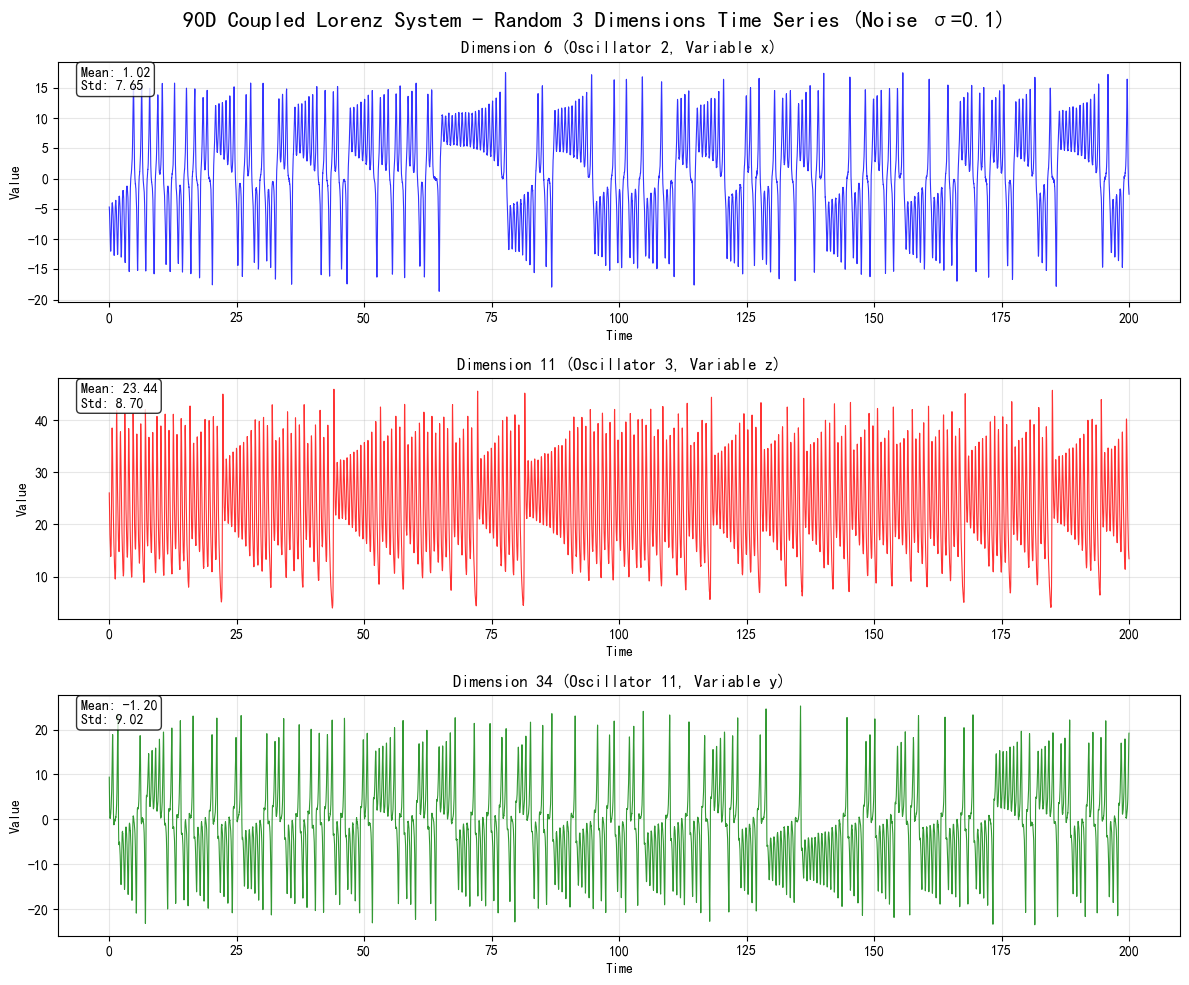

随机选择的维度: [6, 11, 34]


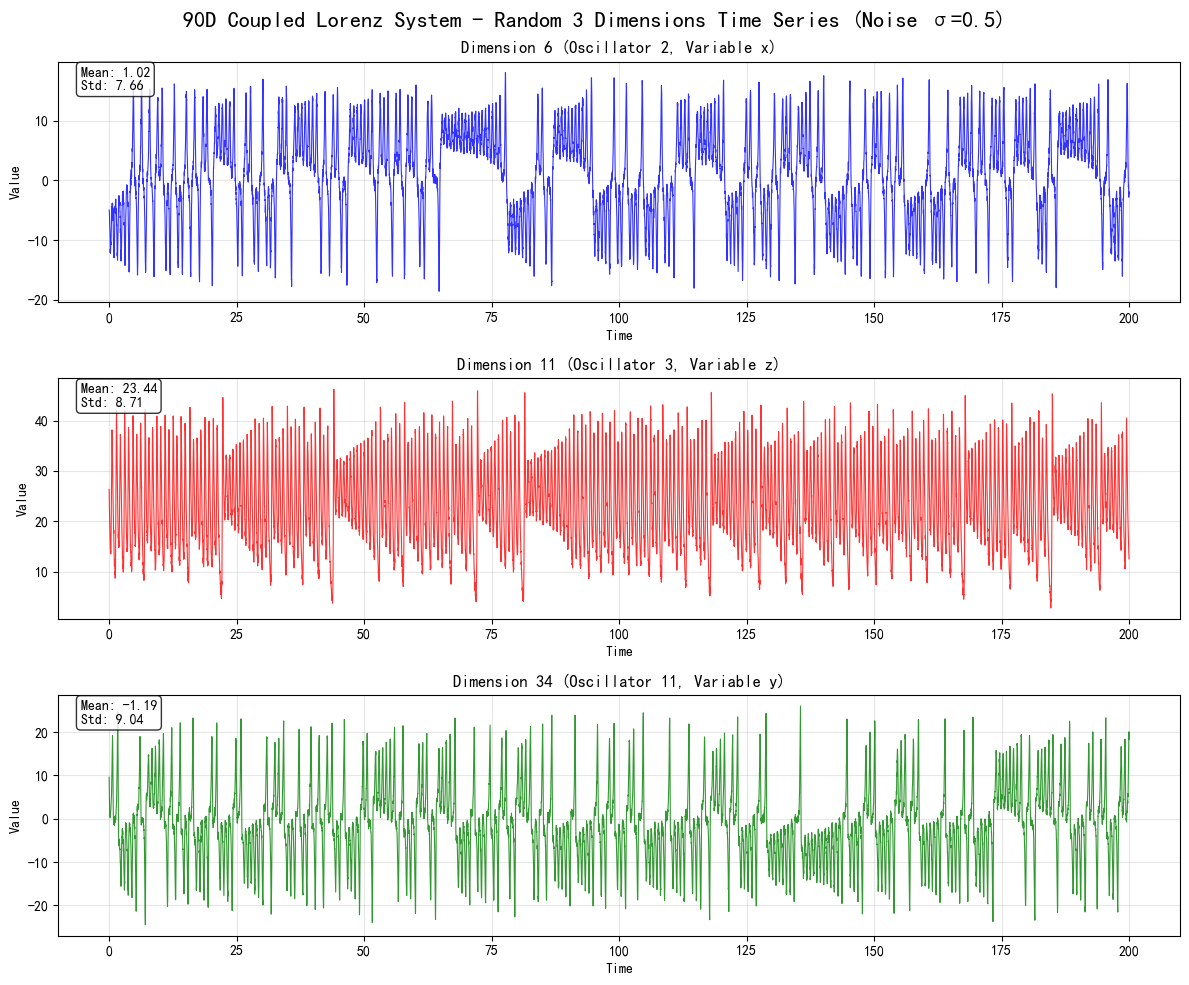

随机选择的维度: [6, 11, 34]


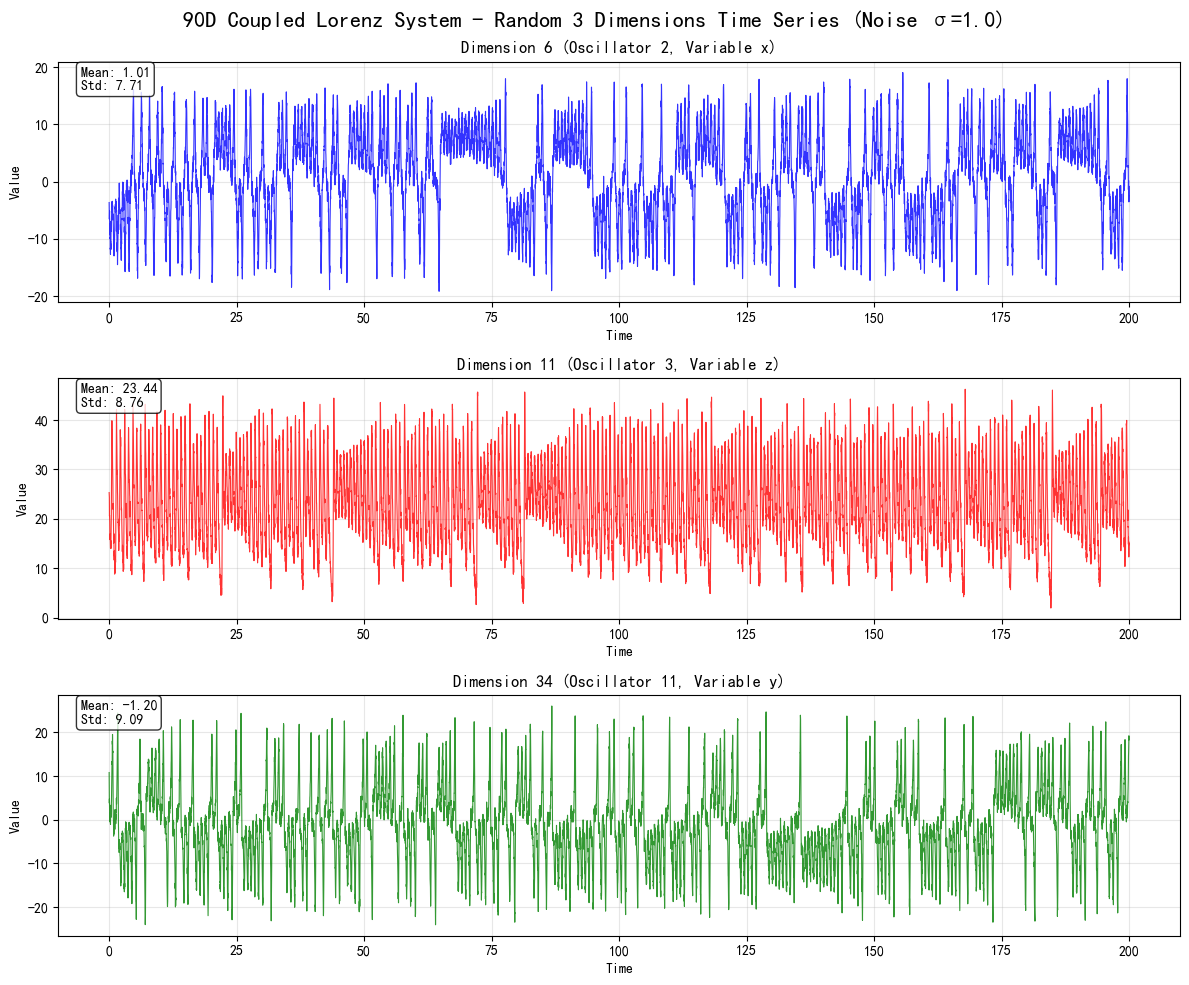


数据生成完成总结
✅ 成功生成 11 个数据集:
   - 时间序列长度: 10000
   - 数据维度: (10000, 90)
   - 时间范围: [0.000, 200.000]
   - 耦合强度: 0.3

📁 生成的文件列表:
   - coupled_lorenz_clean.csv (无噪声) - 6.94 MB
   - coupled_lorenz_noise_0.1.csv (噪声σ=0.1) - 6.94 MB
   - coupled_lorenz_noise_0.2.csv (噪声σ=0.2) - 6.94 MB
   - coupled_lorenz_noise_0.3.csv (噪声σ=0.3) - 6.94 MB
   - coupled_lorenz_noise_0.4.csv (噪声σ=0.4) - 6.94 MB
   - coupled_lorenz_noise_0.5.csv (噪声σ=0.5) - 6.94 MB
   - coupled_lorenz_noise_0.6.csv (噪声σ=0.6) - 6.94 MB
   - coupled_lorenz_noise_0.7.csv (噪声σ=0.7) - 6.94 MB
   - coupled_lorenz_noise_0.8.csv (噪声σ=0.8) - 6.94 MB
   - coupled_lorenz_noise_0.9.csv (噪声σ=0.9) - 6.94 MB
   - coupled_lorenz_noise_1.0.csv (噪声σ=1.0) - 6.94 MB

📊 统计信息:
   - 总文件大小: 76.37 MB
   - 噪声标准差范围: 0.0 - 1.0
   - 时间步长: 0.020002
   - 有效数据点: 10000
   - 丢弃瞬态点: 2000

🎯 数据集用途:
   - 适合机器学习和时间序列预测任务
   - 可用于噪声鲁棒性研究
   - 包含混沌动力学系统的复杂行为
   - 保持动力学特性（观测噪声不影响系统演化）


In [6]:
## 新增 0 到 1 的数据集生成

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
import pandas as pd
from datetime import datetime, timedelta

# 设置matplotlib支持中文字体（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  
plt.rcParams['axes.unicode_minus'] = False

def coupled_lorenz_system(t, state, sigma=10.0, rho=28.0, beta=8.0/3.0, coupling=0.1):
    """
    90维耦合Lorenz系统 (30个Lorenz振子，每个3维)
    采用环形耦合方式
    """
    n_oscillators = 30
    dydt = np.zeros(90)
    
    # 将90维状态向量重塑为30x3的矩阵，便于处理
    state_matrix = state.reshape(n_oscillators, 3)
    
    for i in range(n_oscillators):
        x, y, z = state_matrix[i]
        
        # 环形耦合：每个振子与相邻的两个振子耦合
        left_neighbor = (i - 1) % n_oscillators
        right_neighbor = (i + 1) % n_oscillators
        
        # 耦合项（只在x方向耦合）
        coupling_term = coupling * (
            state_matrix[left_neighbor, 0] + state_matrix[right_neighbor, 0] - 2*x
        )
        
        # Lorenz方程 + 耦合项
        dydt[i*3] = sigma * (y - x) + coupling_term  # dx/dt
        dydt[i*3 + 1] = x * (rho - z) - y             # dy/dt  
        dydt[i*3 + 2] = x * y - beta * z              # dz/dt
    
    return dydt

def generate_data(t_span=(0, 50), n_points=10000, transient_points=2000, 
                 coupling_strength=0.3, noise_std=0.0, noise_seed=None):
    """
    生成耦合Lorenz系统的时间序列数据，自动丢弃瞬态
    
    参数:
    - t_span: 最终数据的时间范围 (start, end)
    - n_points: 最终保留的数据点数
    - transient_points: 丢弃的瞬态点数
    - coupling_strength: 耦合强度
    - noise_std: 高斯观测噪声标准差，0表示无噪声
    - noise_seed: 噪声随机种子，None表示使用随机噪声
    """
    
    # 计算总的采样点数（包含瞬态）
    total_points = n_points + transient_points
    
    # 计算扩展的时间范围（包含瞬态时间）
    total_time_span = t_span[1] - t_span[0]
    dt = total_time_span / (n_points - 1)  # 最终数据的时间步长
    transient_time = transient_points * dt
    extended_t_span = (t_span[0] - transient_time, t_span[1])
    
    # 随机初始条件
    np.random.seed(42)  # 为了可重现性
    initial_conditions = np.random.randn(90) * 0.1
    
    # 扩展的时间点（包含瞬态）
    t_eval = np.linspace(extended_t_span[0], extended_t_span[1], total_points)
    
    noise_info = f", 观测噪声标准差: {noise_std}" if noise_std > 0 else " (无噪声)"
    print("正在求解90维耦合Lorenz系统...")
    print(f"耦合强度: {coupling_strength}")
    print(f"总时间范围 (含瞬态): {extended_t_span}")
    print(f"最终时间范围: {t_span}")
    print(f"总采样点数: {total_points} (瞬态: {transient_points}, 保留: {n_points})")
    print(f"时间步长: {dt:.6f}")
    print(f"瞬态时间: {transient_time:.3f}")
    print(f"数据类型: {noise_info}")
    
    # 求解ODE
    sol = solve_ivp(
        coupled_lorenz_system, 
        extended_t_span, 
        initial_conditions,
        args=(10.0, 28.0, 8.0/3.0, coupling_strength),
        t_eval=t_eval,
        method='RK45',
        rtol=1e-8,
        atol=1e-10
    )
    
    if sol.success:
        print("求解成功!")
        
        # 丢弃瞬态数据
        t_final = sol.t[transient_points:]  # 丢弃前transient_points个时间点
        data_final = sol.y[:, transient_points:].T  # 丢弃前transient_points列，转置为(n_points, 90)
        
        # 重新调整时间起点为t_span[0]
        t_final = t_final - t_final[0] + t_span[0]
        
        print(f"已丢弃前 {transient_points} 个瞬态点")
        print(f"最终数据形状: {data_final.shape}")
        print(f"最终时间范围: [{t_final[0]:.3f}, {t_final[-1]:.3f}]")
        
        # 添加观测噪声（如果需要）
        if noise_std > 0:
            if noise_seed is not None:
                np.random.seed(noise_seed)
            noise = np.random.normal(0, noise_std, data_final.shape)
            data_noisy = data_final + noise
            print(f"已添加标准差为{noise_std}的观测噪声")
            return t_final, data_noisy
        else:
            return t_final, data_final
    else:
        print("求解失败:", sol.message)
        return None, None

def visualize_random_dimensions(t, data, n_dims=3, title_suffix=""):
    """随机选择3个维度进行可视化（使用英文标题）"""
    
    if data is None:
        print("没有数据可以可视化")
        return
    
    # 随机选择3个维度
    random.seed(123)  # 为了可重现性
    selected_dims = random.sample(range(90), n_dims)
    selected_dims.sort()
    
    print(f"随机选择的维度: {selected_dims}")
    
    # 创建子图
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    main_title = f'90D Coupled Lorenz System - Random 3 Dimensions Time Series{title_suffix}'
    fig.suptitle(main_title, fontsize=16)
    
    colors = ['blue', 'red', 'green']
    
    for i, (dim, ax, color) in enumerate(zip(selected_dims, axes, colors)):
        ax.plot(t, data[:, dim], color=color, linewidth=0.8, alpha=0.8)
        ax.set_title(f'Dimension {dim} (Oscillator {dim//3}, Variable {["x", "y", "z"][dim%3]})', fontsize=12)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        # 添加一些统计信息
        mean_val = np.mean(data[:, dim])
        std_val = np.std(data[:, dim])
        ax.text(0.02, 0.98, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return selected_dims

def save_to_csv(t, data, filename='coupled_lorenz_dataset.csv', 
                start_date='2016-01-01 00:00:00', time_unit_seconds=1.0):
    """
    将数据保存为CSV格式，包含日期时间列
    
    参数:
    - t: 时间数组
    - data: 90维数据
    - filename: 保存的文件名
    - start_date: 开始日期时间
    - time_unit_seconds: Lorenz系统中1个时间单位对应的真实秒数
    """
    
    if data is None:
        print("没有数据可以保存")
        return None
    
    print(f"\n正在生成CSV数据集...")
    print(f"时间单位设置: 1 Lorenz时间单位 = {time_unit_seconds} 秒")
    
    # 创建日期时间序列
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    
    # 根据实际的时间步长计算日期时间
    dates = []
    for time_val in t:
        real_seconds = time_val * time_unit_seconds
        date_time = start_datetime + timedelta(seconds=real_seconds)
        dates.append(date_time)
    
    # 创建DataFrame
    df_data = {'date': dates}
    
    # 添加90个维度的数据列 (x1 到 x90)
    for i in range(90):
        df_data[f'x{i+1}'] = data[:, i]
    
    df = pd.DataFrame(df_data)
    
    # 保存到CSV
    df.to_csv(filename, index=False)
    
    print(f"数据已保存到: {filename}")
    print(f"数据形状: {df.shape}")
    print(f"日期范围: {df['date'].iloc[0]} 到 {df['date'].iloc[-1]}")
    print(f"总时间跨度: {df['date'].iloc[-1] - df['date'].iloc[0]}")
    
    # 计算实际的时间间隔
    if len(df) > 1:
        time_diff = (df['date'].iloc[1] - df['date'].iloc[0]).total_seconds()
        print(f"数据点之间的时间间隔: {time_diff:.3f} 秒")
    
    # 显示前几行作为预览
    print(f"\n数据预览:")
    print(df.head())
    
    return df

def analyze_system(data, dataset_name=""):
    """简单的系统分析"""
    if data is None:
        return
    
    print(f"\n=== {dataset_name}系统分析 ===")
    print(f"数据形状: {data.shape}")
    print(f"时间点数: {data.shape[0]}")
    print(f"维度数: {data.shape[1]}")
    
    # 计算每个维度的统计量
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    print(f"\n各维度均值范围: [{np.min(means):.3f}, {np.max(means):.3f}]")
    print(f"各维度标准差范围: [{np.min(stds):.3f}, {np.max(stds):.3f}]")
    
    # 分析每个振子的行为
    print("\n前5个振子(x,y,z)的平均标准差:")
    for i in range(min(5, 30)):  # 只显示前5个振子，避免输出过长
        x_std = stds[i*3]
        y_std = stds[i*3 + 1] 
        z_std = stds[i*3 + 2]
        print(f"振子 {i:2d}: x={x_std:.2f}, y={y_std:.2f}, z={z_std:.2f}")

def compare_noise_effect(data_clean, data_noisy, noise_std):
    """比较观测噪声对数据的影响"""
    print(f"\n=== 观测噪声影响分析 (标准差={noise_std}) ===")
    
    # 计算信噪比 (SNR)
    signal_power = np.mean(data_clean**2, axis=0)
    noise_power = np.mean((data_noisy - data_clean)**2, axis=0)
    snr = 10 * np.log10(signal_power / noise_power)
    
    print(f"平均信噪比 (SNR): {np.mean(snr):.2f} dB")
    print(f"SNR范围: [{np.min(snr):.2f}, {np.max(snr):.2f}] dB")
    
    # 计算相关系数
    correlations = []
    for i in range(90):
        corr = np.corrcoef(data_clean[:, i], data_noisy[:, i])[0, 1]
        correlations.append(corr)
    
    print(f"平均相关系数: {np.mean(correlations):.4f}")
    print(f"相关系数范围: [{np.min(correlations):.4f}, {np.max(correlations):.4f}]")
    
    # 计算噪声水平
    actual_noise_std = np.sqrt(np.mean(noise_power))
    print(f"实际噪声标准差: {actual_noise_std:.3f}")

if __name__ == "__main__":
    # 参数设置
    time_span = (0, 200)           # 最终数据的时间范围
    n_points = 10000               # 最终保留的数据点数
    transient_points = 2000        # 丢弃的瞬态点数
    coupling = 0.3                 # 预测任务优化的耦合强度
    
    # 定义所有要生成的噪声标准差
    noise_std_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    print("=" * 80)
    print("生成90维耦合Lorenz系统数据集 (多种噪声标准差)")
    print("=" * 80)
    print(f"📋 数据生成配置:")
    print(f"   - 最终数据点数: {n_points}")
    print(f"   - 瞬态点数: {transient_points}")
    print(f"   - 总计算点数: {n_points + transient_points}")
    print(f"   - 噪声标准差: {noise_std_list}")
    print(f"   - 总数据集数量: {len(noise_std_list)} 个")
    
    # 首先生成一次干净数据，后续添加不同标准差的噪声
    print("\n🔹 第一步：生成基础干净数据")
    print("-" * 60)
    t, data_clean = generate_data(
        t_span=time_span, 
        n_points=n_points,
        transient_points=transient_points,
        coupling_strength=coupling, 
        noise_std=0.0
    )
    
    if data_clean is None:
        print("❌ 基础数据生成失败，程序终止")
        exit(1)
    
    # 分析无噪声系统
    analyze_system(data_clean, "无噪声")
    
    # 存储所有生成的数据集信息
    generated_datasets = []
    
    # 循环生成不同噪声标准差的数据集
    print("\n🔹 第二步：生成不同噪声标准差的数据集")
    print("-" * 60)
    
    for i, noise_std in enumerate(noise_std_list):
        print(f"\n>>> 正在生成数据集 {i+1}/{len(noise_std_list)} (噪声标准差={noise_std})")
        print("=" * 50)
        
        if noise_std == 0.0:
            # 无噪声数据集
            data_current = data_clean.copy()
            filename = 'coupled_lorenz_clean.csv'
            dataset_name = "无噪声"
        else:
            # 添加指定标准差的观测噪声
            np.random.seed(123 + int(noise_std * 10))  # 为每个噪声标准差设置不同种子
            noise = np.random.normal(0, noise_std, data_clean.shape)
            data_current = data_clean + noise
            filename = f'coupled_lorenz_noise_{noise_std:.1f}.csv'
            dataset_name = f"噪声σ={noise_std}"
            print(f"已添加标准差为{noise_std}的观测噪声")
        
        # 分析当前数据集
        analyze_system(data_current, dataset_name)
        
        # 保存数据集
        df_current = save_to_csv(
            t, data_current, 
            filename, 
            '2016-01-01 00:00:00', 
            time_unit_seconds=5.0
        )
        
        if df_current is not None:
            file_size = df_current.memory_usage(deep=True).sum() / 1024 / 1024
            generated_datasets.append({
                'noise_std': noise_std,
                'filename': filename,
                'file_size_mb': file_size,
                'dataset_name': dataset_name
            })
            
            # 比较噪声效果（跳过干净数据）
            if noise_std > 0:
                compare_noise_effect(data_clean, data_current, noise_std)
    
    # 3. 可视化示例（选择几个代表性的数据集）
    print("\n🔹 第三步：可视化示例")
    print("-" * 60)
    
    # 可视化干净数据
    selected_dims = visualize_random_dimensions(t, data_clean, title_suffix=" (Clean)")
    
    # 可视化几个不同噪声水平的数据（例如：0.1, 0.5, 1.0）
    example_noise_stds = [0.1, 0.5, 1.0]
    for noise_std in example_noise_stds:
        if noise_std in noise_std_list:
            # 重新生成用于可视化
            np.random.seed(123 + int(noise_std * 10))
            noise = np.random.normal(0, noise_std, data_clean.shape)
            data_vis = data_clean + noise
            visualize_random_dimensions(t, data_vis, title_suffix=f" (Noise σ={noise_std})")
    
    # 4. 总结
    print("\n" + "=" * 80)
    print("数据生成完成总结")
    print("=" * 80)
    
    print(f"✅ 成功生成 {len(generated_datasets)} 个数据集:")
    print(f"   - 时间序列长度: {len(t)}")
    print(f"   - 数据维度: {data_clean.shape}")
    print(f"   - 时间范围: [{t[0]:.3f}, {t[-1]:.3f}]")
    print(f"   - 耦合强度: {coupling}")
    
    print(f"\n📁 生成的文件列表:")
    total_size = 0
    for dataset in generated_datasets:
        print(f"   - {dataset['filename']} ({dataset['dataset_name']}) - {dataset['file_size_mb']:.2f} MB")
        total_size += dataset['file_size_mb']
    
    print(f"\n📊 统计信息:")
    print(f"   - 总文件大小: {total_size:.2f} MB")
    print(f"   - 噪声标准差范围: {min(noise_std_list)} - {max(noise_std_list)}")
    print(f"   - 时间步长: {(time_span[1]-time_span[0])/(n_points-1):.6f}")
    print(f"   - 有效数据点: {n_points}")
    print(f"   - 丢弃瞬态点: {transient_points}")
    
    print(f"\n🎯 数据集用途:")
    print(f"   - 适合机器学习和时间序列预测任务")
    print(f"   - 可用于噪声鲁棒性研究")
    print(f"   - 包含混沌动力学系统的复杂行为")
    print(f"   - 保持动力学特性（观测噪声不影响系统演化）")